> # Neural Network Basic - Week3 과제


## Import Library

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [2]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [3]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [50]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        return 1 / (1 + np.exp(-x))

    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        return (1 / (1 + np.exp(-x)))*(1 - (1 / (1 + np.exp(-x))))

In [58]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return np.maximum(0,x)
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        if x > 0:
            return 1
        else:
            return 0

In [6]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [7]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [8]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [17]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200): # 학습률: 0.0001, 500번 반복, 배치 사이즈: 200
        self.lr = lr
        self.epoch = epoch  
        self.batch_size = batch_size
        self.loss_function = cross_entropy # 손실 함수로 cross_entropy를 사용합니다. MNIST 데이터는 클래스가 10개인 범주형 변수이기 때문입니다.
        self.layers = []
        self.activations = [softmax] # 활성화 함수로는 softmax를 사용합니다. 위에서 클래스로 정의하였습니다.
        self.nodes = []
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) 
        if not self.nodes: 
            self.nodes.append(np.zeros(Layer.input_size))
        self.nodes.append(np.zeros(Layer.output_size))
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() # activation 리스트에 담겨있는 클래스 빼기
        self.activations.append(Activation) # 원하는 activation function 넣기
        self.activations.append(tmp) 
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() 
        output = X.copy() 
        for i in range(len(self.layers)): 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            output = np.dot(self.nodes[i], Layer.weight) 
            output = output+ Layer.bias 
            output = Activation.forward(output) 
            self.nodes[i+1] = output 
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): 
            a = self.nodes[i+1] 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            
            if i+1 == len(self.layers): 
                error = Activation.backward(output, y)
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] 
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            error = np.dot(error, Layer.weight.T) 
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1)
        return np.sum(pre_p==y)/y.shape[0] 
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch): # epoch 만큼 반복함
            for j in range(N//self.batch_size):
                batch_mask = np.random.choice(N, self.batch_size)
                X_batch = X[batch_mask] 
                y_batch = y[batch_mask] 
                output = self._forward(X_batch) 
                self._backward(X_batch, output, y_batch)
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) 
            history["val_acc"].append(self._accuracy(output, val_y)) 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) 
            
            # epoch 10마다 test accuracy와 loss를 출력한다
            if i % 10 == 0: 
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

In [47]:
X_train[np.random.choice(300)]

(784,)

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [52]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [53]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [54]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23145.254836024582
10 test accuracy : 0.1521
10 test loss     : 22894.52668313785
20 test accuracy : 0.1962
20 test loss     : 22777.43565490577
30 test accuracy : 0.2201
30 test loss     : 22593.354462097544
40 test accuracy : 0.2191
40 test loss     : 22181.79898107608
50 test accuracy : 0.2194
50 test loss     : 21183.56717521342
60 test accuracy : 0.247
60 test loss     : 19667.545334940853
70 test accuracy : 0.4467
70 test loss     : 18188.967927965874
80 test accuracy : 0.4837
80 test loss     : 16390.35705319751
90 test accuracy : 0.5536
90 test loss     : 14345.321151983098
100 test accuracy : 0.6147
100 test loss     : 12511.791605057317
110 test accuracy : 0.6678
110 test loss     : 10939.042924631161
120 test accuracy : 0.718
120 test loss     : 9653.413980151205
130 test accuracy : 0.7534
130 test loss     : 8618.703379355744
140 test accuracy : 0.783
140 test loss     : 7772.043010285333
150 test accuracy : 0.8066
150 test loss   

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

In [76]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn1 = CustomNet(lr=0.01, epoch=200, batch_size=200)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn1.addLayer(Layer(784,100))
nn1.addActivation(sigmoid)
nn1.addLayer(Layer(100,10))

In [77]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn1.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [78]:
history2 = nn1.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 22994.912351102565
10 test accuracy : 0.2218
10 test loss     : 22208.01860973518
20 test accuracy : 0.4699
20 test loss     : 15725.653476508436
30 test accuracy : 0.7117
30 test loss     : 9943.216709535283
40 test accuracy : 0.825
40 test loss     : 6676.1345466863795
50 test accuracy : 0.8602
50 test loss     : 5195.489956498349
60 test accuracy : 0.8784
60 test loss     : 4433.307037478572
70 test accuracy : 0.8883
70 test loss     : 3979.944023752122
80 test accuracy : 0.8948
80 test loss     : 3691.665063388583
90 test accuracy : 0.8991
90 test loss     : 3486.5442533103947
100 test accuracy : 0.9044
100 test loss     : 3340.8855856951463
110 test accuracy : 0.9076
110 test loss     : 3237.2015018326297
120 test accuracy : 0.9105
120 test loss     : 3154.7826606851427
130 test accuracy : 0.9118
130 test loss     : 3087.9656209367004
140 test accuracy : 0.9139
140 test loss     : 3036.469216974642
150 test accuracy : 0.9148
150 test loss

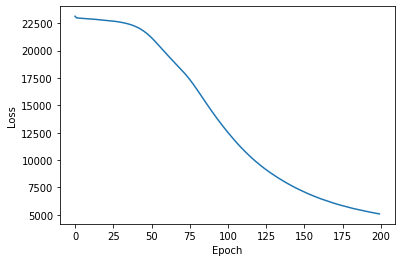

In [84]:
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

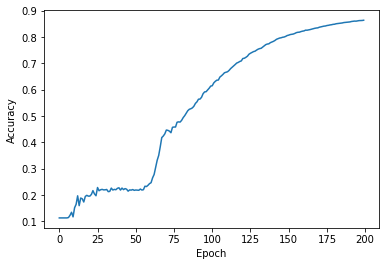

In [86]:
plt.plot(history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()